In [1]:
from helpers import *
from dataset import *
from model2_for81 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [2]:
#DEBAG = False
DEBAG = True

In [3]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    }, 
)

In [4]:
mask_size2 = {
    'defolt': 1,
    'apo-ferritin': mask_size["apo-ferritin"]*0.8,
    'beta-amylase':0,
    'beta-galactosidase': mask_size["beta-galactosidase"]*0.8,
    'ribosome': mask_size["ribosome"]*0.8,
    'thyroglobulin': mask_size["thyroglobulin"]*0.8,
    'virus-like-particle': mask_size["virus-like-particle"]*0.8,
}
print(mask_size2)
mask_check("TS_5_4",mask_size2,cfg)

{'defolt': 1, 'apo-ferritin': 4.800000000000001, 'beta-amylase': 0, 'beta-galactosidase': 7.2, 'ribosome': 12.0, 'thyroglobulin': 10.4, 'virus-like-particle': 10.8}
['TS_5_4']
 TS_5_4 virus-like-particle


(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
 0         apo-ferritin  41  46   37     9   4   0.902439  0.804348  0.809524   
 1         beta-amylase  10  10   10     0   0   1.000000  1.000000  1.000000   
 2   beta-galactosidase  12  12   12     0   0   1.000000  1.000000  1.000000   
 3             ribosome  30  31   29     2   1   0.966667  0.935484  0.937262   
 4        thyroglobulin  30  30   30     0   0   1.000000  1.000000  1.000000   
 5  virus-like-particle  11  11   11     0   0   1.000000  1.000000  1.000000   
 
    weight  
 0       1  
 1       0  
 2       2  
 3       1  
 4       2  
 5       1  ,
 0.963826595276894)

(2, 184, 630, 630)
(2, 184, 630, 630)


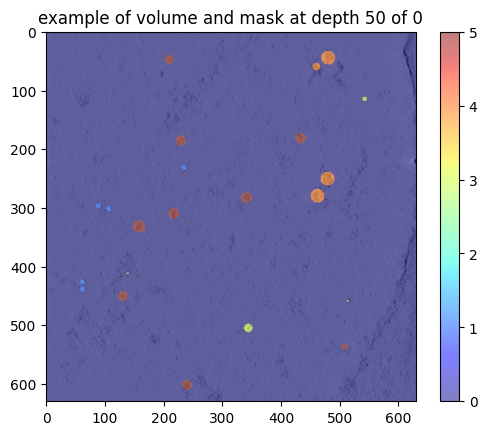

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
diff =["denoised"]

valid_id = ["TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4",'TS_99_9',]
test_id = ["TS_5_4",'TS_99_9',]

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=50)

In [6]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start 
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) >= 0:
                    self.indices.append((idx, start, end))
            start = d - patch_size
            end = d
            if np.sum(mask_data[idx][start:end]) >= 0:
                self.indices.append((idx, start, end))


    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)

    def __getitem__(self, i):
        idx, start, end = self.indices[i]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
        
    # 4. ランダム90度回転を適用
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    
    # 6. パディングを適用して (32, 640, 640) に拡張
    SpatialPadd(keys=["image", "label"], spatial_size=(32, 640, 640), mode="constant", method="end"),
    
])


In [7]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)
# データを取り出す
#i = 0
#print(len(dataloader))  # 6
#for volume, mask in dataloader:
#    i += 1
#    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
#    print_slices(volume[0], mask[0], dim=3, idx=0, depth=16)
#    if i == 3:
#        break

22
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


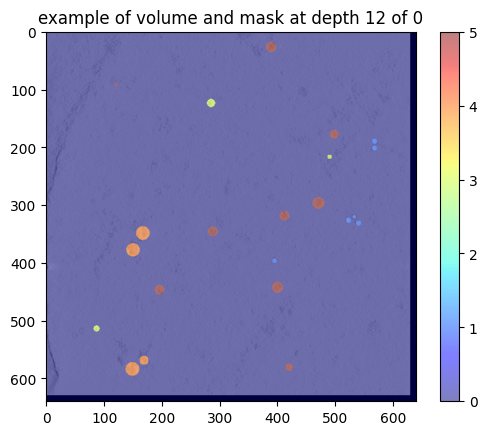

503029
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


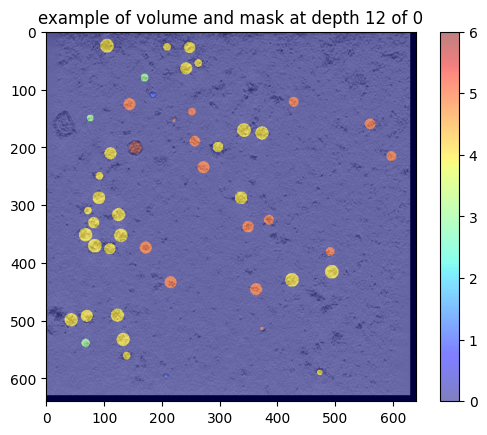

1356588


In [8]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [9]:
GPU_ID = 0
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=False,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

cuda:0


In [10]:
global train_batch, test_batch

In [11]:
from torch.optim.lr_scheduler import LambdaLR
from IPython.display import clear_output
from tqdm import tqdm

# 学習ループにCV計算を追加
num_epochs = 300
learning_rate = 1e-3
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in tqdm(range(num_epochs)):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 5 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  0%|          | 0/300 [00:00<?, ?it/s]

エポック 1/300
----------
train_loss: 2.4500
valid_loss: 2.2689
CVスコア 0.0000
         particle_type    P   T  hit  precision  recall  f-beta4
0         apo-ferritin  550  82    0        0.0     0.0      0.0
1         beta-amylase    2  31    0        0.0     0.0      0.0
2   beta-galactosidase    2  36    0        0.0     0.0      0.0
3             ribosome    2  96    0        0.0     0.0      0.0
4        thyroglobulin    8  79    0        0.0     0.0      0.0
5  virus-like-particle    2  24    0        0.0     0.0      0.0


  0%|          | 1/300 [00:46<3:53:18, 46.82s/it]

エポック 2/300
----------
train_loss: 2.2196


  1%|          | 2/300 [01:01<2:19:30, 28.09s/it]

エポック 3/300
----------
train_loss: 2.1330


  1%|          | 3/300 [01:16<1:48:44, 21.97s/it]

エポック 4/300
----------
train_loss: 2.0806


  1%|▏         | 4/300 [01:31<1:34:42, 19.20s/it]

エポック 5/300
----------
train_loss: 2.0256


  2%|▏         | 5/300 [01:46<1:26:57, 17.69s/it]

エポック 6/300
----------
train_loss: 1.9707
valid_loss: 1.8842
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  2%|▏         | 6/300 [02:33<2:14:48, 27.51s/it]

エポック 7/300
----------
train_loss: 1.9006


  2%|▏         | 7/300 [02:47<1:54:00, 23.35s/it]

エポック 8/300
----------
train_loss: 1.8307


  3%|▎         | 8/300 [03:02<1:40:29, 20.65s/it]

エポック 9/300
----------
train_loss: 1.7607


  3%|▎         | 9/300 [03:17<1:32:02, 18.98s/it]

エポック 10/300
----------
train_loss: 1.7034


  3%|▎         | 10/300 [03:32<1:25:37, 17.72s/it]

エポック 11/300
----------
train_loss: 1.6491
valid_loss: 1.6942
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  4%|▎         | 11/300 [04:19<2:07:40, 26.51s/it]

エポック 12/300
----------
train_loss: 1.5971


  4%|▍         | 12/300 [04:34<1:50:09, 22.95s/it]

エポック 13/300
----------
train_loss: 1.5472


  4%|▍         | 13/300 [04:48<1:37:59, 20.49s/it]

エポック 14/300
----------
train_loss: 1.4991


  5%|▍         | 14/300 [05:04<1:30:05, 18.90s/it]

エポック 15/300
----------
train_loss: 1.4512


  5%|▌         | 15/300 [05:19<1:24:02, 17.69s/it]

エポック 16/300
----------
train_loss: 1.4048
valid_loss: 1.5481
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  5%|▌         | 16/300 [06:05<2:04:41, 26.34s/it]

エポック 17/300
----------
train_loss: 1.3587


  6%|▌         | 17/300 [06:20<1:47:37, 22.82s/it]

エポック 18/300
----------
train_loss: 1.3137


  6%|▌         | 18/300 [06:34<1:36:01, 20.43s/it]

エポック 19/300
----------
train_loss: 1.2701


  6%|▋         | 19/300 [06:49<1:27:50, 18.76s/it]

エポック 20/300
----------
train_loss: 1.2270


  7%|▋         | 20/300 [07:04<1:22:04, 17.59s/it]

エポック 21/300
----------
train_loss: 1.1851
valid_loss: 1.2385
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  7%|▋         | 21/300 [07:51<2:02:17, 26.30s/it]

エポック 22/300
----------
train_loss: 1.1439


  7%|▋         | 22/300 [08:06<1:46:16, 22.94s/it]

エポック 23/300
----------
train_loss: 1.1032


  8%|▊         | 23/300 [08:21<1:34:42, 20.51s/it]

エポック 24/300
----------
train_loss: 1.0640


  8%|▊         | 24/300 [08:37<1:28:21, 19.21s/it]

エポック 25/300
----------
train_loss: 1.0257


  8%|▊         | 25/300 [08:52<1:22:11, 17.93s/it]

エポック 26/300
----------
train_loss: 0.9875
valid_loss: 0.9781
CVスコア 0.0002
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin  12247  82    1   0.000082  0.012195  0.001254
1         beta-amylase      2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase      2  36    0   0.000000  0.000000  0.000000
3             ribosome      2  96    0   0.000000  0.000000  0.000000
4        thyroglobulin   3348  79    0   0.000000  0.000000  0.000000
5  virus-like-particle      2  24    0   0.000000  0.000000  0.000000


  9%|▊         | 26/300 [09:39<2:01:37, 26.63s/it]

エポック 27/300
----------
train_loss: 0.9510


  9%|▉         | 27/300 [09:54<1:45:04, 23.09s/it]

エポック 28/300
----------
train_loss: 0.9156


  9%|▉         | 28/300 [10:09<1:33:47, 20.69s/it]

エポック 29/300
----------
train_loss: 0.8803


 10%|▉         | 29/300 [10:24<1:25:32, 18.94s/it]

エポック 30/300
----------
train_loss: 0.8477


 10%|█         | 30/300 [10:38<1:19:40, 17.70s/it]

エポック 31/300
----------
train_loss: 0.8162
valid_loss: 0.8295
CVスコア 0.0835
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1072  82    6   0.005597  0.073171  0.042785
1         beta-amylase     2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase     2  36    0   0.000000  0.000000  0.000000
3             ribosome     2  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  1499  79   44   0.029353  0.556962  0.270720
5  virus-like-particle     2  24    0   0.000000  0.000000  0.000000


 10%|█         | 31/300 [11:25<1:58:30, 26.43s/it]

エポック 32/300
----------
train_loss: 0.7855


 11%|█         | 32/300 [11:40<1:42:37, 22.98s/it]

エポック 33/300
----------
train_loss: 0.7559


 11%|█         | 33/300 [11:55<1:31:32, 20.57s/it]

エポック 34/300
----------
train_loss: 0.7285


 11%|█▏        | 34/300 [12:10<1:23:57, 18.94s/it]

エポック 35/300
----------
train_loss: 0.7011


 12%|█▏        | 35/300 [12:25<1:18:02, 17.67s/it]

エポック 36/300
----------
train_loss: 0.6751
valid_loss: 0.7068
CVスコア 0.1435
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin    535  82    4   0.007477  0.048780  0.036816
1         beta-amylase  60777  31    1   0.000016  0.032258  0.000277
2   beta-galactosidase      2  36    0   0.000000  0.000000  0.000000
3             ribosome      2  96    0   0.000000  0.000000  0.000000
4        thyroglobulin    528  79   51   0.096591  0.645570  0.483817
5  virus-like-particle      3  24    0   0.000000  0.000000  0.000000


 12%|█▏        | 36/300 [13:13<1:57:15, 26.65s/it]

エポック 37/300
----------
train_loss: 0.6528


 12%|█▏        | 37/300 [13:28<1:41:29, 23.15s/it]

エポック 38/300
----------
train_loss: 0.6334


 13%|█▎        | 38/300 [13:42<1:30:18, 20.68s/it]

エポック 39/300
----------
train_loss: 0.6109


 13%|█▎        | 39/300 [13:57<1:22:27, 18.95s/it]

エポック 40/300
----------
train_loss: 0.5876


 13%|█▎        | 40/300 [14:13<1:18:14, 18.06s/it]

エポック 41/300
----------
train_loss: 0.5658


 14%|█▎        | 41/300 [14:59<1:54:19, 26.49s/it]

valid_loss: 0.6323
CVスコア 0.0823
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   811  82    1   0.001233  0.012195  0.008008
1         beta-amylase  1635  31    9   0.005505  0.290323  0.071797
2   beta-galactosidase     2  36    0   0.000000  0.000000  0.000000
3             ribosome     2  96    0   0.000000  0.000000  0.000000
4        thyroglobulin   951  79   37   0.038906  0.468354  0.283973
5  virus-like-particle   417  24    0   0.000000  0.000000  0.000000
エポック 42/300
----------


 14%|█▍        | 42/300 [15:13<1:37:04, 22.58s/it]

train_loss: 0.5458
エポック 43/300
----------


 14%|█▍        | 43/300 [15:26<1:25:01, 19.85s/it]

train_loss: 0.5281
エポック 44/300
----------


 15%|█▍        | 44/300 [15:40<1:16:42, 17.98s/it]

train_loss: 0.5079
エポック 45/300
----------


 15%|█▌        | 45/300 [15:54<1:10:44, 16.65s/it]

train_loss: 0.4908
エポック 46/300
----------
train_loss: 0.4734


 15%|█▌        | 46/300 [16:40<1:47:40, 25.43s/it]

valid_loss: 0.5076
CVスコア 0.0880
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin   1085  82    4   0.003687  0.048780  0.028369
1         beta-amylase   1066  31   10   0.009381  0.322581  0.108835
2   beta-galactosidase      8  36    0   0.000000  0.000000  0.000000
3             ribosome  14164  96    0   0.000000  0.000000  0.000000
4        thyroglobulin   1181  79   34   0.028789  0.430380  0.236401
5  virus-like-particle   1097  24   10   0.009116  0.416667  0.114787
エポック 47/300
----------


 16%|█▌        | 47/300 [16:53<1:31:59, 21.81s/it]

train_loss: 0.4575
エポック 48/300
----------


 16%|█▌        | 48/300 [17:06<1:21:09, 19.33s/it]

train_loss: 0.4403
エポック 49/300
----------


 16%|█▋        | 49/300 [17:20<1:13:35, 17.59s/it]

train_loss: 0.4253
エポック 50/300
----------


 17%|█▋        | 50/300 [17:34<1:08:15, 16.38s/it]

train_loss: 0.4100
エポック 51/300
----------
train_loss: 0.3933


 17%|█▋        | 51/300 [18:19<1:44:24, 25.16s/it]

valid_loss: 0.4992
CVスコア 0.0479
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin   2153  82    6   0.002787  0.073171  0.029437
1         beta-amylase   1082  31    2   0.001848  0.064516  0.021546
2   beta-galactosidase      6  36    0   0.000000  0.000000  0.000000
3             ribosome  48841  96    0   0.000000  0.000000  0.000000
4        thyroglobulin   3797  79   28   0.007374  0.354430  0.094053
5  virus-like-particle    916  24    9   0.009825  0.375000  0.117692
エポック 52/300
----------


 17%|█▋        | 52/300 [18:33<1:29:25, 21.63s/it]

train_loss: 0.3733
エポック 53/300
----------


 18%|█▊        | 53/300 [18:46<1:18:58, 19.18s/it]

train_loss: 0.3500
エポック 54/300
----------


 18%|█▊        | 54/300 [18:59<1:11:35, 17.46s/it]

train_loss: 0.3364
エポック 55/300
----------


 18%|█▊        | 55/300 [19:13<1:06:31, 16.29s/it]

train_loss: 0.2844
エポック 56/300
----------
train_loss: 0.2583


 19%|█▊        | 56/300 [19:58<1:41:47, 25.03s/it]

valid_loss: 0.2743
CVスコア 0.0256
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin   4525  82    7   0.001547  0.085366  0.020387
1         beta-amylase   2082  31    4   0.001921  0.129032  0.026377
2   beta-galactosidase  20739  36    5   0.000241  0.138889  0.003988
3             ribosome  13262  96    5   0.000377  0.052083  0.005744
4        thyroglobulin  11401  79   51   0.004473  0.645570  0.068456
5  virus-like-particle   3824  24    2   0.000523  0.083333  0.008080
エポック 57/300
----------


 19%|█▉        | 57/300 [20:12<1:27:16, 21.55s/it]

train_loss: 0.2396
エポック 58/300
----------


 19%|█▉        | 58/300 [20:25<1:17:16, 19.16s/it]

train_loss: 0.2231
エポック 59/300
----------


 20%|█▉        | 59/300 [20:39<1:10:11, 17.47s/it]

train_loss: 0.2094
エポック 60/300
----------


 20%|██        | 60/300 [20:53<1:05:14, 16.31s/it]

train_loss: 0.1977
エポック 61/300
----------
train_loss: 0.1871


 20%|██        | 61/300 [21:38<1:40:11, 25.15s/it]

valid_loss: 0.1944
CVスコア 0.0667
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   557  82    1   0.001795  0.012195  0.009096
1         beta-amylase  3007  31    8   0.002660  0.258065  0.038824
2   beta-galactosidase  9845  36   12   0.001219  0.333333  0.019576
3             ribosome  8877  96   14   0.001577  0.145833  0.022856
4        thyroglobulin  4981  79   68   0.013652  0.860759  0.185108
5  virus-like-particle  4861  24    8   0.001646  0.333333  0.025929
エポック 62/300
----------


 21%|██        | 62/300 [21:52<1:25:45, 21.62s/it]

train_loss: 0.1773
エポック 63/300
----------


 21%|██        | 63/300 [22:05<1:15:52, 19.21s/it]

train_loss: 0.1685
エポック 64/300
----------


 21%|██▏       | 64/300 [22:19<1:08:50, 17.50s/it]

train_loss: 0.1606
エポック 65/300
----------


 22%|██▏       | 65/300 [22:32<1:03:54, 16.32s/it]

train_loss: 0.1533
エポック 66/300
----------
train_loss: 0.1469
valid_loss: 0.1545
CVスコア 0.1587
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin    104  82    0   0.000000  0.000000  0.000000
1         beta-amylase  10041  31   11   0.001096  0.354839  0.017747
2   beta-galactosidase  10847  36   22   0.002028  0.611111  0.032741
3             ribosome   7282  96   54   0.007416  0.562500  0.104105
4        thyroglobulin   1261  79   66   0.052339  0.835443  0.444356
5  virus-like-particle   6109  24   20   0.003274  0.833333  0.052364


 22%|██▏       | 66/300 [23:18<1:38:12, 25.18s/it]

エポック 67/300
----------
train_loss: 0.1404


 22%|██▏       | 67/300 [23:33<1:25:50, 22.10s/it]

エポック 68/300
----------
train_loss: 0.1348


 23%|██▎       | 68/300 [23:48<1:17:13, 19.97s/it]

エポック 69/300
----------
train_loss: 0.1296


 23%|██▎       | 69/300 [24:03<1:10:58, 18.43s/it]

エポック 70/300
----------
train_loss: 0.1245


 23%|██▎       | 70/300 [24:18<1:06:48, 17.43s/it]

エポック 71/300
----------
train_loss: 0.1197
valid_loss: 0.1252
CVスコア 0.2209
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  1959  31    2   0.001021  0.064516  0.013849
2   beta-galactosidase  2762  36   19   0.006879  0.527778  0.096765
3             ribosome  1907  96   64   0.033561  0.666667  0.316003
4        thyroglobulin   716  79   52   0.072626  0.658228  0.446465
5  virus-like-particle  1155  24   13   0.011255  0.541667  0.143600


 24%|██▎       | 71/300 [25:03<1:37:40, 25.59s/it]

エポック 72/300
----------
train_loss: 0.1161


 24%|██▍       | 72/300 [25:18<1:25:00, 22.37s/it]

エポック 73/300
----------
train_loss: 0.1148


 24%|██▍       | 73/300 [25:32<1:16:03, 20.10s/it]

エポック 74/300
----------
train_loss: 0.1098


 25%|██▍       | 74/300 [25:47<1:09:55, 18.56s/it]

エポック 75/300
----------
train_loss: 0.1056


 25%|██▌       | 75/300 [26:02<1:05:20, 17.43s/it]

エポック 76/300
----------
train_loss: 0.1015
valid_loss: 0.1178
CVスコア 0.2329
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase   238  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  2386  36   20   0.008382  0.555556  0.114787
3             ribosome  1186  96   24   0.020236  0.250000  0.149890
4        thyroglobulin   756  79   57   0.075397  0.721519  0.479703
5  virus-like-particle   725  24   19   0.026207  0.791667  0.291253


 25%|██▌       | 76/300 [26:47<1:35:41, 25.63s/it]

エポック 77/300
----------
train_loss: 0.0982


 26%|██▌       | 77/300 [27:02<1:23:08, 22.37s/it]

エポック 78/300
----------
train_loss: 0.0955


 26%|██▌       | 78/300 [27:17<1:14:37, 20.17s/it]

エポック 79/300
----------
train_loss: 0.0925


 26%|██▋       | 79/300 [27:32<1:08:35, 18.62s/it]

エポック 80/300
----------
train_loss: 0.0902


 27%|██▋       | 80/300 [27:47<1:04:16, 17.53s/it]

エポック 81/300
----------
train_loss: 0.0870
valid_loss: 0.0914
CVスコア 0.2951
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase   82  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  510  36   12   0.023529  0.333333  0.187845
3             ribosome  847  96   39   0.046045  0.406250  0.278221
4        thyroglobulin  567  79   55   0.097002  0.696203  0.510650
5  virus-like-particle  487  24   20   0.041068  0.833333  0.390356


 27%|██▋       | 81/300 [28:31<1:33:12, 25.54s/it]

エポック 82/300
----------
train_loss: 0.0841


 27%|██▋       | 82/300 [28:46<1:21:07, 22.33s/it]

エポック 83/300
----------
train_loss: 0.0825


 28%|██▊       | 83/300 [29:01<1:12:39, 20.09s/it]

エポック 84/300
----------
train_loss: 0.0803


 28%|██▊       | 84/300 [29:16<1:06:43, 18.53s/it]

エポック 85/300
----------
train_loss: 0.0777


 28%|██▊       | 85/300 [29:31<1:03:34, 17.74s/it]

エポック 86/300
----------
train_loss: 0.0762


 29%|██▊       | 86/300 [30:15<1:30:25, 25.35s/it]

valid_loss: 0.0837
CVスコア 0.2889
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    5  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  437  36   14   0.032037  0.388889  0.234946
3             ribosome  593  96   46   0.077572  0.479167  0.367309
4        thyroglobulin  417  79   39   0.093525  0.493671  0.394408
5  virus-like-particle  260  24   15   0.057692  0.625000  0.395963
エポック 87/300
----------


 29%|██▉       | 87/300 [30:28<1:17:20, 21.79s/it]

train_loss: 0.0750
エポック 88/300
----------


 29%|██▉       | 88/300 [30:42<1:08:12, 19.30s/it]

train_loss: 0.0728
エポック 89/300
----------


 30%|██▉       | 89/300 [30:55<1:01:46, 17.57s/it]

train_loss: 0.0717
エポック 90/300
----------


 30%|███       | 90/300 [31:09<57:13, 16.35s/it]  

train_loss: 0.0708
エポック 91/300
----------
train_loss: 0.0679


 30%|███       | 91/300 [31:51<1:24:26, 24.24s/it]

valid_loss: 0.0814
CVスコア 0.2300
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    1  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   43  36    0   0.000000  0.000000  0.000000
3             ribosome  761  96   55   0.072273  0.572917  0.407053
4        thyroglobulin  451  79   46   0.101996  0.582278  0.455977
5  virus-like-particle  376  24   13   0.034574  0.541667  0.290789
エポック 92/300
----------


 31%|███       | 92/300 [32:05<1:12:47, 21.00s/it]

train_loss: 0.0668
エポック 93/300
----------


 31%|███       | 93/300 [32:18<1:04:45, 18.77s/it]

train_loss: 0.0648
エポック 94/300
----------


 31%|███▏      | 94/300 [32:32<59:04, 17.21s/it]  

train_loss: 0.0633
エポック 95/300
----------


 32%|███▏      | 95/300 [32:45<55:00, 16.10s/it]

train_loss: 0.0616
エポック 96/300
----------
train_loss: 0.0604


 32%|███▏      | 96/300 [33:28<1:21:39, 24.02s/it]

valid_loss: 0.0752
CVスコア 0.2764
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  510  36   10   0.019608  0.277778  0.156538
3             ribosome  694  96   61   0.087896  0.635417  0.465022
4        thyroglobulin  517  79   42   0.081238  0.531646  0.400898
5  virus-like-particle  287  24   14   0.048780  0.583333  0.354694
エポック 97/300
----------


 32%|███▏      | 97/300 [33:41<1:10:28, 20.83s/it]

train_loss: 0.0590
エポック 98/300
----------


 33%|███▎      | 98/300 [33:55<1:02:41, 18.62s/it]

train_loss: 0.0591
エポック 99/300
----------


 33%|███▎      | 99/300 [34:08<57:13, 17.08s/it]  

train_loss: 0.0581
エポック 100/300
----------


 33%|███▎      | 100/300 [34:22<53:22, 16.01s/it]

train_loss: 0.0567
エポック 101/300
----------
train_loss: 0.0560


 34%|███▎      | 101/300 [35:05<1:20:05, 24.15s/it]

valid_loss: 0.0787
CVスコア 0.2154
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    8  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  683  36    8   0.011713  0.222222  0.108022
3             ribosome  706  96   44   0.062323  0.458333  0.333631
4        thyroglobulin  701  79   41   0.058488  0.518987  0.354707
5  virus-like-particle  709  24   16   0.022567  0.666667  0.248856
エポック 102/300
----------


 34%|███▍      | 102/300 [35:18<1:09:05, 20.94s/it]

train_loss: 0.0553
エポック 103/300
----------


 34%|███▍      | 103/300 [35:32<1:01:24, 18.70s/it]

train_loss: 0.0554
エポック 104/300
----------


 35%|███▍      | 104/300 [35:45<56:00, 17.15s/it]  

train_loss: 0.0545
エポック 105/300
----------


 35%|███▌      | 105/300 [35:59<52:15, 16.08s/it]

train_loss: 0.0531
エポック 106/300
----------
train_loss: 0.0514


 35%|███▌      | 106/300 [36:41<1:17:37, 24.01s/it]

valid_loss: 0.0657
CVスコア 0.2847
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    6  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  465  36    9   0.019355  0.250000  0.146974
3             ribosome  654  96   59   0.090214  0.614583  0.457991
4        thyroglobulin  571  79   47   0.082312  0.594937  0.435422
5  virus-like-particle  397  24   17   0.042821  0.708333  0.370038
エポック 107/300
----------


 36%|███▌      | 107/300 [36:55<1:06:58, 20.82s/it]

train_loss: 0.0508
エポック 108/300
----------


 36%|███▌      | 108/300 [37:08<59:24, 18.57s/it]  

train_loss: 0.0490
エポック 109/300
----------


 36%|███▋      | 109/300 [37:21<54:10, 17.02s/it]

train_loss: 0.0483
エポック 110/300
----------


 37%|███▋      | 110/300 [37:35<50:32, 15.96s/it]

train_loss: 0.0475
エポック 111/300
----------
train_loss: 0.0476


 37%|███▋      | 111/300 [38:18<1:16:21, 24.24s/it]

valid_loss: 0.0606
CVスコア 0.2599
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  227  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  330  36   10   0.030303  0.277778  0.187638
3             ribosome  614  96   50   0.081433  0.520833  0.395349
4        thyroglobulin  599  79   41   0.068447  0.518987  0.374128
5  virus-like-particle  465  24   15   0.032258  0.625000  0.300353
エポック 112/300
----------


 37%|███▋      | 112/300 [38:32<1:05:44, 20.98s/it]

train_loss: 0.0468
エポック 113/300
----------


 38%|███▊      | 113/300 [38:45<58:21, 18.73s/it]  

train_loss: 0.0455
エポック 114/300
----------


 38%|███▊      | 114/300 [38:59<53:19, 17.20s/it]

train_loss: 0.0454
エポック 115/300
----------


 38%|███▊      | 115/300 [39:13<49:41, 16.11s/it]

train_loss: 0.0442
エポック 116/300
----------
train_loss: 0.0434


 39%|███▊      | 116/300 [39:56<1:14:15, 24.21s/it]

valid_loss: 0.0745
CVスコア 0.2462
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  638  31    3   0.004702  0.096774  0.044974
2   beta-galactosidase  558  36   11   0.019713  0.305556  0.164903
3             ribosome  701  96   58   0.082739  0.604167  0.440769
4        thyroglobulin  699  79   38   0.054363  0.481013  0.329088
5  virus-like-particle  539  24   16   0.029685  0.666667  0.294691
エポック 117/300
----------


 39%|███▉      | 117/300 [40:09<1:03:57, 20.97s/it]

train_loss: 0.0439
エポック 118/300
----------


 39%|███▉      | 118/300 [40:23<56:53, 18.75s/it]  

train_loss: 0.0426
エポック 119/300
----------


 40%|███▉      | 119/300 [40:36<51:56, 17.22s/it]

train_loss: 0.0422
エポック 120/300
----------


 40%|████      | 120/300 [40:50<48:16, 16.09s/it]

train_loss: 0.0409
エポック 121/300
----------
train_loss: 0.0413


 40%|████      | 121/300 [41:32<1:11:43, 24.04s/it]

valid_loss: 0.0679
CVスコア 0.2732
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  318  31    1   0.003145  0.032258  0.020885
2   beta-galactosidase  363  36    9   0.024793  0.250000  0.162939
3             ribosome  544  96   59   0.108456  0.614583  0.482212
4        thyroglobulin  486  79   35   0.072016  0.443038  0.340000
5  virus-like-particle  297  24   17   0.057239  0.708333  0.424376
エポック 122/300
----------


 41%|████      | 122/300 [41:46<1:01:53, 20.86s/it]

train_loss: 0.0398
エポック 123/300
----------


 41%|████      | 123/300 [41:59<54:57, 18.63s/it]  

train_loss: 0.0392
エポック 124/300
----------


 41%|████▏     | 124/300 [42:13<50:14, 17.13s/it]

train_loss: 0.0403
エポック 125/300
----------


 42%|████▏     | 125/300 [42:26<46:52, 16.07s/it]

train_loss: 0.0385
エポック 126/300
----------
train_loss: 0.0387


 42%|████▏     | 126/300 [43:09<1:09:39, 24.02s/it]

valid_loss: 0.0606
CVスコア 0.2895
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  194  31    2   0.010309  0.064516  0.049275
2   beta-galactosidase  283  36    8   0.028269  0.222222  0.158324
3             ribosome  395  96   59   0.149367  0.614583  0.519420
4        thyroglobulin  362  79   35   0.096685  0.443038  0.365929
5  virus-like-particle  246  24   17   0.069106  0.708333  0.458730
エポック 127/300
----------


 42%|████▏     | 127/300 [43:22<1:00:06, 20.85s/it]

train_loss: 0.0390
エポック 128/300
----------


 43%|████▎     | 128/300 [43:36<53:25, 18.63s/it]  

train_loss: 0.0370
エポック 129/300
----------


 43%|████▎     | 129/300 [43:49<48:46, 17.11s/it]

train_loss: 0.0367
エポック 130/300
----------


 43%|████▎     | 130/300 [44:03<45:32, 16.08s/it]

train_loss: 0.0362
エポック 131/300
----------
train_loss: 0.0370
valid_loss: 0.0562
CVスコア 0.2986
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    1  82    0   0.000000  0.000000  0.000000
1         beta-amylase  421  31    4   0.009501  0.129032  0.074155
2   beta-galactosidase  566  36   13   0.022968  0.361111  0.193520
3             ribosome  755  96   65   0.086093  0.677083  0.482322
4        thyroglobulin  805  79   54   0.067081  0.683544  0.443693
5  virus-like-particle  533  24   18   0.033771  0.750000  0.333697


 44%|████▎     | 131/300 [44:48<1:09:58, 24.84s/it]

エポック 132/300
----------
train_loss: 0.0360


 44%|████▍     | 132/300 [45:03<1:01:07, 21.83s/it]

エポック 133/300
----------
train_loss: 0.0352


 44%|████▍     | 133/300 [45:18<54:56, 19.74s/it]  

エポック 134/300
----------
train_loss: 0.0356


 45%|████▍     | 134/300 [45:33<50:37, 18.30s/it]

エポック 135/300
----------
train_loss: 0.0352


 45%|████▌     | 135/300 [45:48<47:34, 17.30s/it]

エポック 136/300
----------
train_loss: 0.0336
valid_loss: 0.0613
CVスコア 0.3001
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    1  82    0   0.000000  0.000000  0.000000
1         beta-amylase  581  31    2   0.003442  0.064516  0.031569
2   beta-galactosidase  728  36   14   0.019231  0.388889  0.182515
3             ribosome  821  96   66   0.080390  0.687500  0.476029
4        thyroglobulin  870  79   56   0.064368  0.708861  0.446111
5  virus-like-particle  587  24   21   0.035775  0.875000  0.367662


 45%|████▌     | 136/300 [46:33<1:09:51, 25.56s/it]

エポック 137/300
----------
train_loss: 0.0341


 46%|████▌     | 137/300 [46:48<1:00:44, 22.36s/it]

エポック 138/300
----------
train_loss: 0.0333


 46%|████▌     | 138/300 [47:02<54:11, 20.07s/it]  

エポック 139/300
----------
train_loss: 0.0340


 46%|████▋     | 139/300 [47:17<49:42, 18.53s/it]

エポック 140/300
----------
train_loss: 0.0315


 47%|████▋     | 140/300 [47:32<46:25, 17.41s/it]

エポック 141/300
----------
train_loss: 0.0317
valid_loss: 0.0578
CVスコア 0.3179
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  243  31    4   0.016461  0.129032  0.092016
2   beta-galactosidase  480  36   12   0.025000  0.333333  0.193182
3             ribosome  583  96   63   0.108062  0.656250  0.505427
4        thyroglobulin  690  79   44   0.063768  0.556962  0.382805
5  virus-like-particle  125  24   17   0.136000  0.708333  0.567780


 47%|████▋     | 141/300 [48:16<1:07:29, 25.47s/it]

エポック 142/300
----------
train_loss: 0.0303


 47%|████▋     | 142/300 [48:31<58:44, 22.31s/it]  

エポック 143/300
----------
train_loss: 0.0305


 48%|████▊     | 143/300 [48:46<52:22, 20.01s/it]

エポック 144/300
----------
train_loss: 0.0298


 48%|████▊     | 144/300 [49:01<48:03, 18.49s/it]

エポック 145/300
----------
train_loss: 0.0294


 48%|████▊     | 145/300 [49:16<45:00, 17.42s/it]

エポック 146/300
----------
train_loss: 0.0280
valid_loss: 0.0537
CVスコア 0.3192
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  130  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  258  36    9   0.034884  0.250000  0.183453
3             ribosome  376  96   61   0.162234  0.635417  0.542364
4        thyroglobulin  592  79   43   0.072635  0.544304  0.393858
5  virus-like-particle  154  24   17   0.110390  0.708333  0.537175


 49%|████▊     | 146/300 [50:00<1:05:08, 25.38s/it]

エポック 147/300
----------
train_loss: 0.0274


 49%|████▉     | 147/300 [50:15<56:39, 22.22s/it]  

エポック 148/300
----------
train_loss: 0.0267


 49%|████▉     | 148/300 [50:29<50:38, 19.99s/it]

エポック 149/300
----------
train_loss: 0.0259


 50%|████▉     | 149/300 [50:44<46:24, 18.44s/it]

エポック 150/300
----------
train_loss: 0.0261


 50%|█████     | 150/300 [50:59<43:24, 17.37s/it]

エポック 151/300
----------
train_loss: 0.0260


 50%|█████     | 151/300 [51:42<1:01:56, 24.94s/it]

valid_loss: 0.0530
CVスコア 0.3110
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin     0  82    0   0.000000  0.000000  0.000000
1         beta-amylase   234  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   567  36   16   0.028219  0.444444  0.237970
3             ribosome   488  96   63   0.129098  0.656250  0.529150
4        thyroglobulin  1098  79   53   0.048270  0.670886  0.381456
5  virus-like-particle   198  24   14   0.070707  0.583333  0.408935
エポック 152/300
----------


 51%|█████     | 152/300 [51:55<52:58, 21.48s/it]  

train_loss: 0.0259
エポック 153/300
----------


 51%|█████     | 153/300 [52:09<46:45, 19.08s/it]

train_loss: 0.0281
エポック 154/300
----------


 51%|█████▏    | 154/300 [52:22<42:21, 17.40s/it]

train_loss: 0.0281
エポック 155/300
----------


 52%|█████▏    | 155/300 [52:36<39:13, 16.23s/it]

train_loss: 0.0264
エポック 156/300
----------
train_loss: 0.0251


 52%|█████▏    | 156/300 [53:18<57:49, 24.09s/it]

valid_loss: 0.0580
CVスコア 0.3075
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase   62  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  233  36    5   0.021459  0.138889  0.105068
3             ribosome  221  96   52   0.235294  0.541667  0.503130
4        thyroglobulin  518  79   48   0.092664  0.607595  0.457912
5  virus-like-particle  103  24   15   0.145631  0.625000  0.523614
エポック 157/300
----------


 52%|█████▏    | 157/300 [53:32<49:46, 20.89s/it]

train_loss: 0.0244
エポック 158/300
----------


 53%|█████▎    | 158/300 [53:45<44:11, 18.67s/it]

train_loss: 0.0243
エポック 159/300
----------


 53%|█████▎    | 159/300 [53:58<40:09, 17.09s/it]

train_loss: 0.0239
エポック 160/300
----------


 53%|█████▎    | 160/300 [54:12<37:20, 16.00s/it]

train_loss: 0.0226
エポック 161/300
----------
train_loss: 0.0219


 54%|█████▎    | 161/300 [54:54<55:27, 23.94s/it]

valid_loss: 0.0513
CVスコア 0.3168
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  196  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  420  36   11   0.026190  0.305556  0.187751
3             ribosome  429  96   60   0.139860  0.625000  0.519084
4        thyroglobulin  665  79   51   0.076692  0.645570  0.449456
5  virus-like-particle  337  24   18   0.053412  0.750000  0.424411
エポック 162/300
----------


 54%|█████▍    | 162/300 [55:08<47:45, 20.76s/it]

train_loss: 0.0214
エポック 163/300
----------


 54%|█████▍    | 163/300 [55:21<42:25, 18.58s/it]

train_loss: 0.0217
エポック 164/300
----------


 55%|█████▍    | 164/300 [55:35<38:41, 17.07s/it]

train_loss: 0.0219
エポック 165/300
----------


 55%|█████▌    | 165/300 [55:48<36:01, 16.01s/it]

train_loss: 0.0214
エポック 166/300
----------
train_loss: 0.0201
valid_loss: 0.0609
CVスコア 0.3243
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  376  31    2   0.005319  0.064516  0.038991
2   beta-galactosidase  530  36   15   0.028302  0.416667  0.230561
3             ribosome  490  96   54   0.110204  0.562500  0.453110
4        thyroglobulin  701  79   52   0.074180  0.658228  0.449873
5  virus-like-particle  250  24   17   0.068000  0.708333  0.455836


 55%|█████▌    | 166/300 [56:32<54:19, 24.33s/it]

エポック 167/300
----------
train_loss: 0.0202


 56%|█████▌    | 167/300 [56:47<47:30, 21.44s/it]

エポック 168/300
----------
train_loss: 0.0191


 56%|█████▌    | 168/300 [57:02<42:49, 19.47s/it]

エポック 169/300
----------
train_loss: 0.0198


 56%|█████▋    | 169/300 [57:16<39:25, 18.06s/it]

エポック 170/300
----------
train_loss: 0.0188


 57%|█████▋    | 170/300 [57:31<37:00, 17.08s/it]

エポック 171/300
----------
train_loss: 0.0184


 57%|█████▋    | 171/300 [58:14<53:07, 24.71s/it]

valid_loss: 0.0579
CVスコア 0.3176
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  165  82    4   0.024242  0.048780  0.046039
1         beta-amylase  447  31    8   0.017897  0.258065  0.144221
2   beta-galactosidase  447  36   12   0.026846  0.333333  0.199413
3             ribosome  549  96   64   0.116576  0.666667  0.521823
4        thyroglobulin  537  79   47   0.087523  0.594937  0.443642
5  virus-like-particle  445  24   18   0.040449  0.750000  0.369119
エポック 172/300
----------


 57%|█████▋    | 172/300 [58:27<45:30, 21.33s/it]

train_loss: 0.0183
エポック 173/300
----------


 58%|█████▊    | 173/300 [58:41<40:12, 19.00s/it]

train_loss: 0.0185
エポック 174/300
----------


 58%|█████▊    | 174/300 [58:54<36:25, 17.35s/it]

train_loss: 0.0177
エポック 175/300
----------


 58%|█████▊    | 175/300 [59:08<33:43, 16.19s/it]

train_loss: 0.0176
エポック 176/300
----------
train_loss: 0.0180


 59%|█████▊    | 176/300 [59:50<49:55, 24.16s/it]

valid_loss: 0.0648
CVスコア 0.3055
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  321  82    8   0.024922  0.097561  0.083282
1         beta-amylase  638  31    6   0.009404  0.193548  0.089947
2   beta-galactosidase  610  36   16   0.026230  0.444444  0.229342
3             ribosome  631  96   51   0.080824  0.531250  0.400092
4        thyroglobulin  687  79   50   0.072780  0.632911  0.435674
5  virus-like-particle  609  24   19   0.031199  0.791667  0.325277
エポック 177/300
----------


 59%|█████▉    | 177/300 [1:00:04<42:58, 20.96s/it]

train_loss: 0.0177
エポック 178/300
----------


 59%|█████▉    | 178/300 [1:00:17<38:04, 18.72s/it]

train_loss: 0.0180
エポック 179/300
----------


 60%|█████▉    | 179/300 [1:00:31<34:38, 17.18s/it]

train_loss: 0.0177
エポック 180/300
----------


 60%|██████    | 180/300 [1:00:45<32:11, 16.10s/it]

train_loss: 0.0176
エポック 181/300
----------
train_loss: 0.0185


 60%|██████    | 181/300 [1:01:27<47:40, 24.04s/it]

valid_loss: 0.0624
CVスコア 0.3186
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  305  82    9   0.029508  0.109756  0.094620
1         beta-amylase  550  31   10   0.018182  0.322581  0.162524
2   beta-galactosidase  618  36   18   0.029126  0.500000  0.256281
3             ribosome  676  96   48   0.071006  0.500000  0.368897
4        thyroglobulin  731  79   59   0.080711  0.746835  0.502757
5  virus-like-particle  573  24   14   0.024433  0.583333  0.248694
エポック 182/300
----------


 61%|██████    | 182/300 [1:01:41<41:00, 20.85s/it]

train_loss: 0.0171
エポック 183/300
----------


 61%|██████    | 183/300 [1:01:54<36:19, 18.63s/it]

train_loss: 0.0171
エポック 184/300
----------


 61%|██████▏   | 184/300 [1:02:07<32:58, 17.05s/it]

train_loss: 0.0165
エポック 185/300
----------


 62%|██████▏   | 185/300 [1:02:21<30:42, 16.02s/it]

train_loss: 0.0165
エポック 186/300
----------
train_loss: 0.0161
valid_loss: 0.0560
CVスコア 0.3725
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  388  82   15   0.038660  0.182927  0.150000
1         beta-amylase  659  31    8   0.012140  0.258065  0.117749
2   beta-galactosidase  658  36   21   0.031915  0.583333  0.289303
3             ribosome  665  96   65   0.097744  0.677083  0.502045
4        thyroglobulin  672  79   62   0.092262  0.784810  0.544421
5  virus-like-particle  679  24   18   0.026510  0.750000  0.287865


 62%|██████▏   | 186/300 [1:03:05<46:24, 24.42s/it]

エポック 187/300
----------
train_loss: 0.0160


 62%|██████▏   | 187/300 [1:03:20<40:37, 21.57s/it]

エポック 188/300
----------
train_loss: 0.0157


 63%|██████▎   | 188/300 [1:03:35<36:30, 19.56s/it]

エポック 189/300
----------
train_loss: 0.0153


 63%|██████▎   | 189/300 [1:03:49<33:29, 18.10s/it]

エポック 190/300
----------
train_loss: 0.0149


 63%|██████▎   | 190/300 [1:04:04<31:22, 17.12s/it]

エポック 191/300
----------
train_loss: 0.0150


 64%|██████▎   | 191/300 [1:04:47<45:17, 24.93s/it]

valid_loss: 0.0754
CVスコア 0.3118
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  627  31   10   0.015949  0.322581  0.151380
2   beta-galactosidase  749  36   22   0.029372  0.611111  0.282264
3             ribosome  523  96   33   0.063098  0.343750  0.272462
4        thyroglobulin  580  79   57   0.098276  0.721519  0.525488
5  virus-like-particle  771  24   20   0.025940  0.833333  0.294372
エポック 192/300
----------


 64%|██████▍   | 192/300 [1:05:01<38:37, 21.46s/it]

train_loss: 0.0144
エポック 193/300
----------


 64%|██████▍   | 193/300 [1:05:14<33:58, 19.05s/it]

train_loss: 0.0147
エポック 194/300
----------


 65%|██████▍   | 194/300 [1:05:28<30:43, 17.39s/it]

train_loss: 0.0146
エポック 195/300
----------


 65%|██████▌   | 195/300 [1:05:41<28:23, 16.22s/it]

train_loss: 0.0154
エポック 196/300
----------
train_loss: 0.0154


 65%|██████▌   | 196/300 [1:06:24<41:56, 24.19s/it]

valid_loss: 0.0546
CVスコア 0.3519
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  527  31    6   0.011385  0.193548  0.099707
2   beta-galactosidase  583  36   22   0.037736  0.611111  0.322692
3             ribosome  419  96   57   0.136038  0.593750  0.495652
4        thyroglobulin  432  79   51   0.118056  0.645570  0.511203
5  virus-like-particle  637  24   18   0.028257  0.750000  0.299706
エポック 197/300
----------


 66%|██████▌   | 197/300 [1:06:37<35:58, 20.95s/it]

train_loss: 0.0140
エポック 198/300
----------


 66%|██████▌   | 198/300 [1:06:51<31:48, 18.71s/it]

train_loss: 0.0138
エポック 199/300
----------


 66%|██████▋   | 199/300 [1:07:05<28:56, 17.19s/it]

train_loss: 0.0131
エポック 200/300
----------


 67%|██████▋   | 200/300 [1:07:18<26:49, 16.09s/it]

train_loss: 0.0126
エポック 201/300
----------
train_loss: 0.0128


 67%|██████▋   | 201/300 [1:08:01<39:43, 24.07s/it]

valid_loss: 0.0591
CVスコア 0.3249
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  754  31    7   0.009284  0.225806  0.095200
2   beta-galactosidase  743  36   21   0.028264  0.583333  0.270660
3             ribosome  691  96   57   0.082489  0.593750  0.435115
4        thyroglobulin  681  79   57   0.083700  0.721519  0.498201
5  virus-like-particle  801  24   21   0.026217  0.875000  0.301266
エポック 202/300
----------


 67%|██████▋   | 202/300 [1:08:14<34:06, 20.89s/it]

train_loss: 0.0128
エポック 203/300
----------


 68%|██████▊   | 203/300 [1:08:28<30:09, 18.65s/it]

train_loss: 0.0120
エポック 204/300
----------


 68%|██████▊   | 204/300 [1:08:41<27:22, 17.11s/it]

train_loss: 0.0119
エポック 205/300
----------


 68%|██████▊   | 205/300 [1:08:55<25:26, 16.06s/it]

train_loss: 0.0125
エポック 206/300
----------
train_loss: 0.0132
valid_loss: 0.0530
CVスコア 0.3950
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  473  31    9   0.019027  0.290323  0.157895
2   beta-galactosidase  583  36   22   0.037736  0.611111  0.322692
3             ribosome  221  96   65   0.294118  0.677083  0.628913
4        thyroglobulin  482  79   59   0.122407  0.746835  0.574456
5  virus-like-particle  611  24   20   0.032733  0.833333  0.341709


 69%|██████▊   | 206/300 [1:09:39<38:13, 24.40s/it]

エポック 207/300
----------
train_loss: 0.0126


 69%|██████▉   | 207/300 [1:09:53<33:20, 21.51s/it]

エポック 208/300
----------
train_loss: 0.0135


 69%|██████▉   | 208/300 [1:10:08<29:54, 19.51s/it]

エポック 209/300
----------
train_loss: 0.0121


 70%|██████▉   | 209/300 [1:10:23<27:28, 18.12s/it]

エポック 210/300
----------
train_loss: 0.0121


 70%|███████   | 210/300 [1:10:38<25:43, 17.14s/it]

エポック 211/300
----------
train_loss: 0.0111


 70%|███████   | 211/300 [1:11:21<37:03, 24.99s/it]

valid_loss: 0.0614
CVスコア 0.3444
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  564  31    9   0.015957  0.290323  0.144340
2   beta-galactosidase  764  36   22   0.028796  0.611111  0.279104
3             ribosome  330  96   56   0.169697  0.583333  0.510182
4        thyroglobulin  541  79   54   0.099815  0.683544  0.508587
5  virus-like-particle  765  24   22   0.028758  0.916667  0.325500
エポック 212/300
----------


 71%|███████   | 212/300 [1:11:35<31:31, 21.50s/it]

train_loss: 0.0113
エポック 213/300
----------


 71%|███████   | 213/300 [1:11:48<27:41, 19.10s/it]

train_loss: 0.0128
エポック 214/300
----------


 71%|███████▏  | 214/300 [1:12:02<25:01, 17.46s/it]

train_loss: 0.0127
エポック 215/300
----------


 72%|███████▏  | 215/300 [1:12:15<23:03, 16.28s/it]

train_loss: 0.0116
エポック 216/300
----------
train_loss: 0.0114


 72%|███████▏  | 216/300 [1:12:58<33:49, 24.16s/it]

valid_loss: 0.0536
CVスコア 0.3642
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase  523  31    8   0.015296  0.258065  0.133464
2   beta-galactosidase  733  36   22   0.030014  0.611111  0.285714
3             ribosome  120  96   60   0.500000  0.625000  0.615942
4        thyroglobulin  562  79   56   0.099644  0.708861  0.521358
5  virus-like-particle  733  24   21   0.028649  0.875000  0.319606
エポック 217/300
----------


 72%|███████▏  | 217/300 [1:13:11<28:57, 20.93s/it]

train_loss: 0.0111
エポック 218/300
----------


 73%|███████▎  | 218/300 [1:13:25<25:32, 18.69s/it]

train_loss: 0.0106
エポック 219/300
----------


 73%|███████▎  | 219/300 [1:13:38<23:08, 17.15s/it]

train_loss: 0.0100
エポック 220/300
----------


 73%|███████▎  | 220/300 [1:13:52<21:22, 16.03s/it]

train_loss: 0.0096
エポック 221/300
----------
train_loss: 0.0103


 74%|███████▎  | 221/300 [1:14:34<31:35, 23.99s/it]

valid_loss: 0.0560
CVスコア 0.3820
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   57  82    3   0.052632  0.036585  0.037253
1         beta-amylase  423  31    7   0.016548  0.225806  0.129489
2   beta-galactosidase  629  36   22   0.034976  0.611111  0.310373
3             ribosome  128  96   62   0.484375  0.645833  0.633413
4        thyroglobulin  421  79   51   0.121140  0.645570  0.514540
5  virus-like-particle  673  24   22   0.032689  0.916667  0.353832
エポック 222/300
----------


 74%|███████▍  | 222/300 [1:14:48<27:02, 20.80s/it]

train_loss: 0.0093
エポック 223/300
----------


 74%|███████▍  | 223/300 [1:15:01<23:50, 18.58s/it]

train_loss: 0.0099
エポック 224/300
----------


 75%|███████▍  | 224/300 [1:15:14<21:36, 17.06s/it]

train_loss: 0.0099
エポック 225/300
----------


 75%|███████▌  | 225/300 [1:15:28<19:57, 15.97s/it]

train_loss: 0.0092
エポック 226/300
----------
train_loss: 0.0097
valid_loss: 0.0628
CVスコア 0.4135
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  102  82   14   0.137255  0.170732  0.168317
1         beta-amylase  280  31    3   0.010714  0.096774  0.065722
2   beta-galactosidase  528  36   22   0.041667  0.611111  0.338768
3             ribosome  111  96   59   0.531532  0.614583  0.608986
4        thyroglobulin  317  79   50   0.157729  0.632911  0.537634
5  virus-like-particle  549  24   20   0.036430  0.833333  0.364416


 75%|███████▌  | 226/300 [1:16:12<30:02, 24.36s/it]

エポック 227/300
----------
train_loss: 0.0090


 76%|███████▌  | 227/300 [1:16:27<26:06, 21.46s/it]

エポック 228/300
----------
train_loss: 0.0087


 76%|███████▌  | 228/300 [1:16:41<23:22, 19.47s/it]

エポック 229/300
----------
train_loss: 0.0087


 76%|███████▋  | 229/300 [1:16:56<21:24, 18.09s/it]

エポック 230/300
----------
train_loss: 0.0088


 77%|███████▋  | 230/300 [1:17:11<19:57, 17.10s/it]

エポック 231/300
----------
train_loss: 0.0091


 77%|███████▋  | 231/300 [1:17:54<28:31, 24.81s/it]

valid_loss: 0.0551
CVスコア 0.3809
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  409  82   23   0.056235  0.280488  0.227193
1         beta-amylase  551  31    9   0.016334  0.290323  0.146132
2   beta-galactosidase  776  36   21   0.027062  0.583333  0.264053
3             ribosome  105  96   53   0.504762  0.552083  0.549055
4        thyroglobulin  497  79   56   0.112676  0.708861  0.540602
5  virus-like-particle  828  24   20   0.024155  0.833333  0.280528
エポック 232/300
----------


 77%|███████▋  | 232/300 [1:18:07<24:15, 21.40s/it]

train_loss: 0.0089
エポック 233/300
----------


 78%|███████▊  | 233/300 [1:18:21<21:14, 19.02s/it]

train_loss: 0.0084
エポック 234/300
----------


 78%|███████▊  | 234/300 [1:18:34<19:06, 17.38s/it]

train_loss: 0.0087
エポック 235/300
----------


 78%|███████▊  | 235/300 [1:18:48<17:33, 16.21s/it]

train_loss: 0.0080
エポック 236/300
----------
train_loss: 0.0087
valid_loss: 0.0493
CVスコア 0.4222
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  276  82   25   0.090580  0.304878  0.267632
1         beta-amylase  322  31    7   0.021739  0.225806  0.145477
2   beta-galactosidase  565  36   22   0.038938  0.611111  0.327783
3             ribosome  105  96   64   0.609524  0.666667  0.663010
4        thyroglobulin  357  79   48   0.134454  0.607595  0.503393
5  virus-like-particle  601  24   21   0.034942  0.875000  0.362437


 79%|███████▊  | 236/300 [1:19:32<26:13, 24.58s/it]

エポック 237/300
----------
train_loss: 0.0084


 79%|███████▉  | 237/300 [1:19:47<22:45, 21.68s/it]

エポック 238/300
----------
train_loss: 0.0079


 79%|███████▉  | 238/300 [1:20:02<20:14, 19.59s/it]

エポック 239/300
----------
train_loss: 0.0086


 80%|███████▉  | 239/300 [1:20:16<18:29, 18.18s/it]

エポック 240/300
----------
train_loss: 0.0083


 80%|████████  | 240/300 [1:20:31<17:13, 17.22s/it]

エポック 241/300
----------
train_loss: 0.0081


 80%|████████  | 241/300 [1:21:14<24:28, 24.88s/it]

valid_loss: 0.0400
CVスコア 0.3905
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  588  82   14   0.023810  0.170732  0.125263
1         beta-amylase  538  31    9   0.016729  0.290323  0.147969
2   beta-galactosidase  867  36   24   0.027682  0.666667  0.282744
3             ribosome  104  96   65   0.625000  0.677083  0.673780
4        thyroglobulin  566  79   58   0.102473  0.734177  0.538798
5  virus-like-particle  901  24   22   0.024417  0.916667  0.291051
エポック 242/300
----------


 81%|████████  | 242/300 [1:21:27<20:42, 21.42s/it]

train_loss: 0.0091
エポック 243/300
----------


 81%|████████  | 243/300 [1:21:41<18:05, 19.04s/it]

train_loss: 0.0089
エポック 244/300
----------


 81%|████████▏ | 244/300 [1:21:55<16:14, 17.39s/it]

train_loss: 0.0091
エポック 245/300
----------


 82%|████████▏ | 245/300 [1:22:08<14:52, 16.22s/it]

train_loss: 0.0084
エポック 246/300
----------
train_loss: 0.0080


 82%|████████▏ | 246/300 [1:22:50<21:40, 24.08s/it]

valid_loss: 0.0643
CVスコア 0.3365
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  642  82   18   0.028037  0.219512  0.156602
1         beta-amylase  502  31    9   0.017928  0.290323  0.153307
2   beta-galactosidase  667  36   23   0.034483  0.638889  0.314562
3             ribosome   88  96   46   0.522727  0.479167  0.481527
4        thyroglobulin  235  79   35   0.148936  0.443038  0.396931
5  virus-like-particle  771  24   20   0.025940  0.833333  0.294372
エポック 247/300
----------


 82%|████████▏ | 247/300 [1:23:04<18:25, 20.86s/it]

train_loss: 0.0080
エポック 248/300
----------


 83%|████████▎ | 248/300 [1:23:17<16:08, 18.63s/it]

train_loss: 0.0075
エポック 249/300
----------


 83%|████████▎ | 249/300 [1:23:31<14:32, 17.11s/it]

train_loss: 0.0077
エポック 250/300
----------


 83%|████████▎ | 250/300 [1:23:44<13:21, 16.04s/it]

train_loss: 0.0073
エポック 251/300
----------
train_loss: 0.0068


 84%|████████▎ | 251/300 [1:24:27<19:36, 24.02s/it]

valid_loss: 0.0630
CVスコア 0.3826
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  787  82   27   0.034307  0.329268  0.218676
1         beta-amylase  483  31   10   0.020704  0.322581  0.173647
2   beta-galactosidase  629  36   22   0.034976  0.611111  0.310373
3             ribosome  101  96   53   0.524752  0.552083  0.550397
4        thyroglobulin  280  79   46   0.164286  0.582278  0.506477
5  virus-like-particle  912  24   21   0.023026  0.875000  0.275463
エポック 252/300
----------


 84%|████████▍ | 252/300 [1:24:40<16:39, 20.83s/it]

train_loss: 0.0067
エポック 253/300
----------


 84%|████████▍ | 253/300 [1:24:54<14:35, 18.62s/it]

train_loss: 0.0071
エポック 254/300
----------


 85%|████████▍ | 254/300 [1:25:07<13:05, 17.08s/it]

train_loss: 0.0068
エポック 255/300
----------


 85%|████████▌ | 255/300 [1:25:21<12:01, 16.03s/it]

train_loss: 0.0069
エポック 256/300
----------
train_loss: 0.0069


 85%|████████▌ | 256/300 [1:26:03<17:35, 24.00s/it]

valid_loss: 0.0620
CVスコア 0.3769
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  523  82   24   0.045889  0.292683  0.222343
1         beta-amylase  258  31    6   0.023256  0.193548  0.135279
2   beta-galactosidase  348  36   19   0.054598  0.527778  0.349567
3             ribosome   85  96   55   0.647059  0.572917  0.576804
4        thyroglobulin  165  79   32   0.193939  0.405063  0.380686
5  virus-like-particle  514  24   20   0.038911  0.833333  0.378619
エポック 257/300
----------


 86%|████████▌ | 257/300 [1:26:17<14:55, 20.82s/it]

train_loss: 0.0075
エポック 258/300
----------


 86%|████████▌ | 258/300 [1:26:30<13:01, 18.60s/it]

train_loss: 0.0074
エポック 259/300
----------


 86%|████████▋ | 259/300 [1:26:44<11:40, 17.08s/it]

train_loss: 0.0071
エポック 260/300
----------


 87%|████████▋ | 260/300 [1:26:57<10:39, 16.00s/it]

train_loss: 0.0067
エポック 261/300
----------
train_loss: 0.0069


 87%|████████▋ | 261/300 [1:27:40<15:33, 23.95s/it]

valid_loss: 0.0683
CVスコア 0.3689
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  718  82   19   0.026462  0.231707  0.159113
1         beta-amylase  350  31    6   0.017143  0.193548  0.120567
2   beta-galactosidase  480  36   20   0.041667  0.555556  0.321970
3             ribosome   60  96   47   0.783333  0.489583  0.500627
4        thyroglobulin  177  79   40   0.225989  0.506329  0.471895
5  virus-like-particle  581  24   19   0.032702  0.791667  0.334715
エポック 262/300
----------


 87%|████████▋ | 262/300 [1:27:53<13:09, 20.77s/it]

train_loss: 0.0077
エポック 263/300
----------


 88%|████████▊ | 263/300 [1:28:06<11:25, 18.54s/it]

train_loss: 0.0078
エポック 264/300
----------


 88%|████████▊ | 264/300 [1:28:20<10:12, 17.01s/it]

train_loss: 0.0073
エポック 265/300
----------


 88%|████████▊ | 265/300 [1:28:33<09:18, 15.96s/it]

train_loss: 0.0075
エポック 266/300
----------
train_loss: 0.0070


 89%|████████▊ | 266/300 [1:29:16<13:35, 23.98s/it]

valid_loss: 0.0717
CVスコア 0.2475
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  861  82   19   0.022067  0.231707  0.148642
1         beta-amylase  465  31    8   0.017204  0.258065  0.141519
2   beta-galactosidase  783  36   22   0.028097  0.611111  0.275202
3             ribosome   60  96   24   0.400000  0.250000  0.255639
4        thyroglobulin  114  79   19   0.166667  0.240506  0.234398
5  virus-like-particle  882  24   23   0.026077  0.958333  0.308847
エポック 267/300
----------


 89%|████████▉ | 267/300 [1:29:30<11:26, 20.80s/it]

train_loss: 0.0066
エポック 268/300
----------


 89%|████████▉ | 268/300 [1:29:43<09:55, 18.62s/it]

train_loss: 0.0067
エポック 269/300
----------


 90%|████████▉ | 269/300 [1:29:57<08:49, 17.09s/it]

train_loss: 0.0065
エポック 270/300
----------


 90%|█████████ | 270/300 [1:30:10<08:00, 16.03s/it]

train_loss: 0.0066
エポック 271/300
----------
train_loss: 0.0063


 90%|█████████ | 271/300 [1:30:53<11:35, 24.00s/it]

valid_loss: 0.0409
CVスコア 0.4207
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  528  82   25   0.047348  0.304878  0.230978
1         beta-amylase    5  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  420  36   20   0.047619  0.555556  0.341365
3             ribosome  107  96   64   0.598131  0.666667  0.662203
4        thyroglobulin  191  79   43   0.225131  0.544304  0.502405
5  virus-like-particle  457  24   18   0.039387  0.750000  0.363853
エポック 272/300
----------


 91%|█████████ | 272/300 [1:31:06<09:42, 20.82s/it]

train_loss: 0.0058
エポック 273/300
----------


 91%|█████████ | 273/300 [1:31:20<08:22, 18.60s/it]

train_loss: 0.0056
エポック 274/300
----------


 91%|█████████▏| 274/300 [1:31:33<07:23, 17.07s/it]

train_loss: 0.0055
エポック 275/300
----------


 92%|█████████▏| 275/300 [1:31:46<06:39, 15.99s/it]

train_loss: 0.0057
エポック 276/300
----------
train_loss: 0.0059


 92%|█████████▏| 276/300 [1:32:29<09:35, 23.98s/it]

valid_loss: 0.0666
CVスコア 0.3771
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  834  82   29   0.034772  0.353659  0.229730
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  550  36   19   0.034545  0.527778  0.286856
3             ribosome  111  96   52   0.468468  0.541667  0.536733
4        thyroglobulin  262  79   43   0.164122  0.544304  0.479030
5  virus-like-particle  562  24   19   0.033808  0.791667  0.341438
エポック 277/300
----------


 92%|█████████▏| 277/300 [1:32:43<07:58, 20.81s/it]

train_loss: 0.0055
エポック 278/300
----------


 93%|█████████▎| 278/300 [1:32:56<06:49, 18.60s/it]

train_loss: 0.0054
エポック 279/300
----------


 93%|█████████▎| 279/300 [1:33:10<05:59, 17.10s/it]

train_loss: 0.0060
エポック 280/300
----------


 93%|█████████▎| 280/300 [1:33:23<05:20, 16.04s/it]

train_loss: 0.0058
エポック 281/300
----------
train_loss: 0.0055


 94%|█████████▎| 281/300 [1:34:06<07:36, 24.03s/it]

valid_loss: 0.0537
CVスコア 0.3631
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  555  82   20   0.036036  0.243902  0.182110
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  357  36   18   0.050420  0.500000  0.327974
3             ribosome   95  96   54   0.568421  0.562500  0.562845
4        thyroglobulin  174  79   36   0.206897  0.455696  0.425591
5  virus-like-particle  438  24   14   0.031963  0.583333  0.289538
エポック 282/300
----------


 94%|█████████▍| 282/300 [1:34:19<06:15, 20.86s/it]

train_loss: 0.0053
エポック 283/300
----------


 94%|█████████▍| 283/300 [1:34:33<05:16, 18.63s/it]

train_loss: 0.0056
エポック 284/300
----------


 95%|█████████▍| 284/300 [1:34:46<04:33, 17.10s/it]

train_loss: 0.0056
エポック 285/300
----------


 95%|█████████▌| 285/300 [1:35:00<04:00, 16.02s/it]

train_loss: 0.0061
エポック 286/300
----------
train_loss: 0.0061


 95%|█████████▌| 286/300 [1:35:42<05:35, 23.96s/it]

valid_loss: 0.0642
CVスコア 0.3653
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  570  82   22   0.038596  0.268293  0.198725
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  371  36   16   0.043127  0.444444  0.287223
3             ribosome   85  96   52   0.611765  0.541667  0.545342
4        thyroglobulin  170  79   36   0.211765  0.455696  0.426778
5  virus-like-particle  367  24   17   0.046322  0.708333  0.384820
エポック 287/300
----------


 96%|█████████▌| 287/300 [1:35:56<04:30, 20.80s/it]

train_loss: 0.0059
エポック 288/300
----------


 96%|█████████▌| 288/300 [1:36:09<03:42, 18.58s/it]

train_loss: 0.0057
エポック 289/300
----------


 96%|█████████▋| 289/300 [1:36:23<03:07, 17.05s/it]

train_loss: 0.0054
エポック 290/300
----------


 97%|█████████▋| 290/300 [1:36:36<02:40, 16.00s/it]

train_loss: 0.0056
エポック 291/300
----------
train_loss: 0.0054


 97%|█████████▋| 291/300 [1:37:19<03:35, 23.97s/it]

valid_loss: 0.0622
CVスコア 0.3853
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  763  82   24   0.031455  0.292683  0.196627
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  483  36   20   0.041408  0.555556  0.321058
3             ribosome  104  96   59   0.567308  0.614583  0.611585
4        thyroglobulin  211  79   38   0.180095  0.481013  0.437966
5  virus-like-particle  532  24   20   0.037594  0.833333  0.371179
エポック 292/300
----------


 97%|█████████▋| 292/300 [1:37:32<02:46, 20.81s/it]

train_loss: 0.0056
エポック 293/300
----------


 98%|█████████▊| 293/300 [1:37:46<02:10, 18.61s/it]

train_loss: 0.0059
エポック 294/300
----------


 98%|█████████▊| 294/300 [1:37:59<01:42, 17.08s/it]

train_loss: 0.0056
エポック 295/300
----------


 98%|█████████▊| 295/300 [1:38:13<01:20, 16.03s/it]

train_loss: 0.0057
エポック 296/300
----------
train_loss: 0.0053


 99%|█████████▊| 296/300 [1:38:55<01:35, 23.96s/it]

valid_loss: 0.0583
CVスコア 0.3871
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  519  82   19   0.036609  0.231707  0.176406
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  354  36   16   0.045198  0.444444  0.292473
3             ribosome   83  96   54   0.650602  0.562500  0.567017
4        thyroglobulin  155  79   38   0.245161  0.481013  0.455250
5  virus-like-particle  266  24   18   0.067669  0.750000  0.470769
エポック 297/300
----------


 99%|█████████▉| 297/300 [1:39:09<01:02, 20.80s/it]

train_loss: 0.0051
エポック 298/300
----------


 99%|█████████▉| 298/300 [1:39:22<00:37, 18.60s/it]

train_loss: 0.0050
エポック 299/300
----------


100%|█████████▉| 299/300 [1:39:36<00:17, 17.08s/it]

train_loss: 0.0049
エポック 300/300
----------


100%|██████████| 300/300 [1:39:49<00:00, 19.96s/it]

train_loss: 0.0046


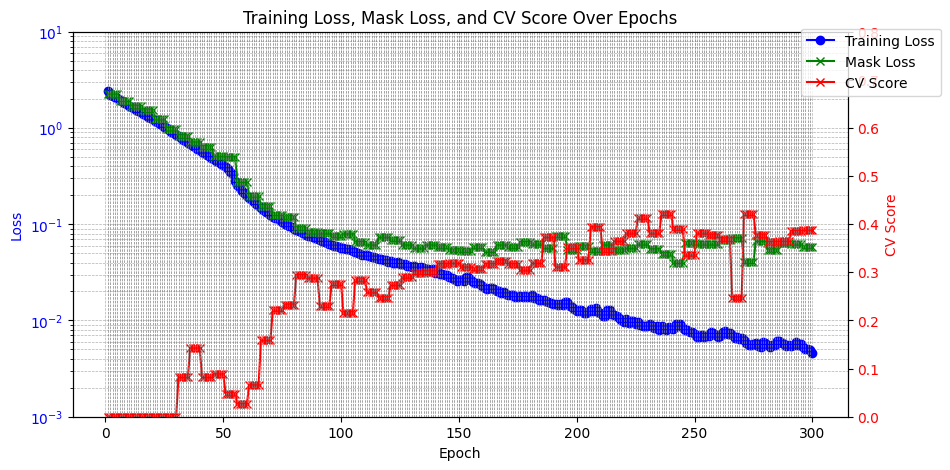

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [13]:
num_epochs = 100
learning_rate = 1e-4
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)
global_step = 0

for epoch in range(num_epochs):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 5 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/100
----------
train_loss: 0.0049
valid_loss: 0.0593
CVスコア 0.3522
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  764  82   22   0.028796  0.268293  0.180154
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  535  36   18   0.033645  0.500000  0.275428
3             ribosome   97  96   55   0.567010  0.572917  0.572566
4        thyroglobulin  172  79   33   0.191860  0.417722  0.390669
5  virus-like-particle  509  24   20   0.039293  0.833333  0.380739
エポック 2/100
----------
train_loss: 0.0045
エポック 3/100
----------
train_loss: 0.0046
エポック 4/100
----------
train_loss: 0.0046
エポック 5/100
----------
train_loss: 0.0042
エポック 6/100
----------
train_loss: 0.0043
valid_loss: 0.0522
CVスコア 0.3772
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  576  82   19   0.032986  0.231707  0.171081
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-g

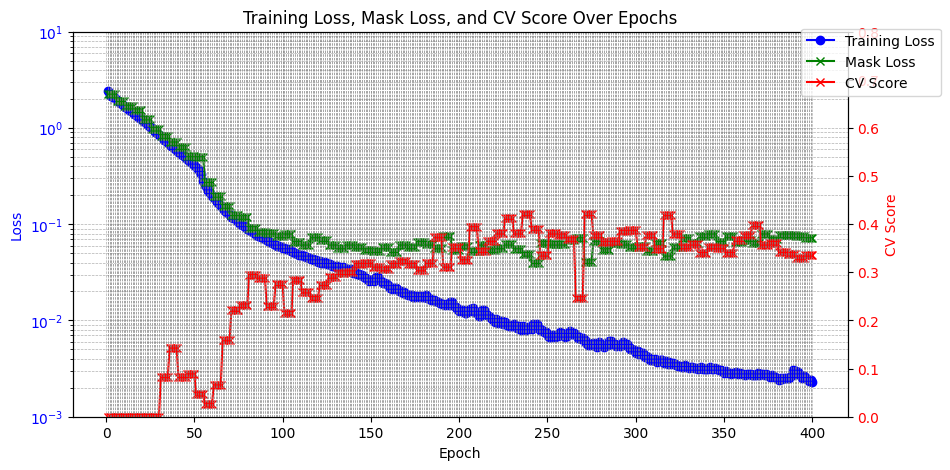

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [15]:
volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

(2, 184, 630, 630)
(2, 184, 630, 630)


Text(0.5, 1.0, 'truth')

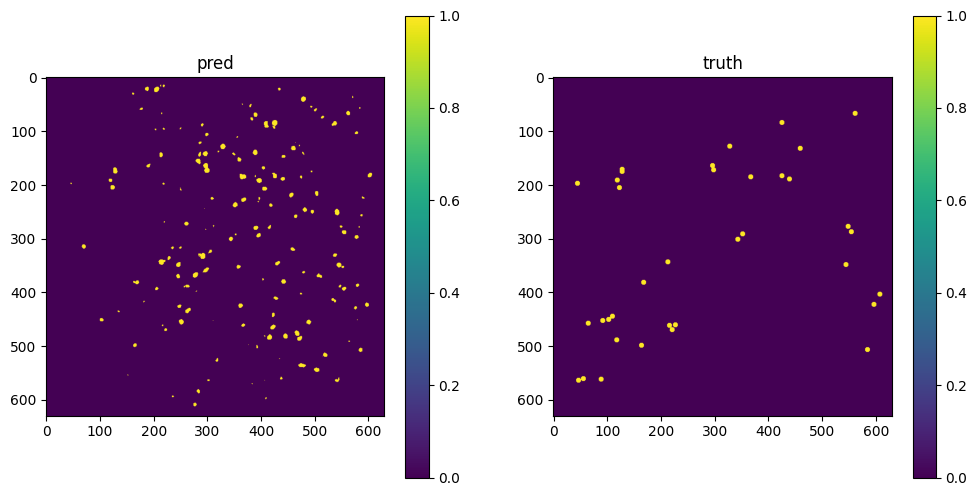

In [22]:
Class =1
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(probability[Class].max(0)>0.7)
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('pred')

on_hot =np.eye(7)[masks]
im2 = axes[1].imshow(on_hot[1,:,:,:,Class].max(0))
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('truth')